# Starbucks A/B Testing Take Home Assignment
========================================

## Background Information (from Udacity)

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

========================================

## Instructions
A randomized experiment was conducted and the results are in 'Training.csv'
* Treatment: indicates if the customer was part of treatment or control
* Purchase: indicates if the customer purchased the product
* ID: customer ID
* V1 to V7: features of the customer

In addition:
* Cost of sending a promotion: \$0.15
* Revenue from purchase of product: \$10 (There is only one product)

## Questions
1. Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue
2. Build a model to select the best customers to target that maximizes the Incremental Response Rate (IRR) and Net Incremental Revenue (NIR)

==========================================================
## Metrics
**IRR** depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion.

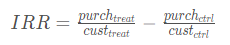


**NIR** depicts how much is made (or lost) by sending out the promotion

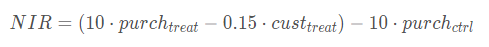

=============================================================
# Libraries

In [1]:
# ==== DATA =====
import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ==== HYPOTHESIS TESTING =====
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

# ===== MODELS =====
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

# ===== HYPERPARAMETER TUNING =====
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# ===== PERFORMANCE MEASURES =====
from sklearn.metrics import f1_score, precision_score, recall_score

==============================================
# Loading the data

In [2]:
df = pd.read_csv('training.csv', index_col = 'ID')
df.head()

,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
ID,,,,,,,,,
1,No,0,2,30.443518,-1.165083,1,1,3,2
3,No,0,3,32.159350,-0.645617,2,3,2,2
4,No,0,2,30.431659,0.133583,1,1,4,2
5,No,0,0,26.588914,-0.212728,2,1,4,2
8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [3]:
# Checking nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84534 entries, 1 to 126184
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Promotion  84534 non-null  object 
 1   purchase   84534 non-null  int64  
 2   V1         84534 non-null  int64  
 3   V2         84534 non-null  float64
 4   V3         84534 non-null  float64
 5   V4         84534 non-null  int64  
 6   V5         84534 non-null  int64  
 7   V6         84534 non-null  int64  
 8   V7         84534 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 6.4+ MB


========================================================

It seems that there are no missing values and that dtypes are correctly specified for each feature.

# 1. Checking A/B Test

## Checking the Invariant Metric
First of all, we should check that the number of visitors assigned to each group is similar. If there is a statistically significant imbalance, our results would be biased and the test should be re-done.

In this case, we want to do a two-sided hypothsesis test on the proportion of visitors assigned to one of our conditions. 

For more information about this approach, check this post https://vitalflux.com/one-proportion-z-test-formula-examples/

In [4]:
# Knowing that...
p = 0.5 # null hypothesis "p" 
n_obs = len(df) # total sample size
n_control = df.Promotion.value_counts()['No']
p_hat = n_control/n_obs # propotion of customers in control group

# We can compute the Z score
z_score = (p_hat - p)/np.sqrt((p*(1-p)/n_obs))

# And from the Z score, we can get our p-value
p_value = 2 * stats.norm.cdf(z_score)
print('{0:0.3f}'.format(p_value))

0.505


We can also get the p_value directly using the "statsmodels" package:

In [5]:
# get p_value for z test on proportions
stat, pval = proportions_ztest(n_control, n_obs, value=0.5, alternative='two-sided')
print('{0:0.3f}'.format(pval))

0.505


==========================================================================

# 2. Analyzing the results of the experiment

In [6]:
n_treat       = df.loc[df['Promotion'] == 'Yes',:].shape[0]
n_control     = df.loc[df['Promotion'] == 'No',:].shape[0]

perc_treat_purch = df.loc[df['Promotion'] == 'Yes', 'purchase'].sum()/n_treat
perc_ctrl_purch  = df.loc[df['Promotion'] == 'No', 'purchase'].sum()/n_control

print(f'n_treat_purch: {perc_treat_purch:.2%}')
print(f'n_ctrl_purch: {perc_ctrl_purch:.2%}')

n_treat_purch: 1.70%
n_ctrl_purch: 0.76%


### Calculate IRR and NIR

In [7]:
def get_eval_metrics(data, print_results=True):
    """Given a dataset, it computes the IRR and the NIR
    Arguments:
        data: pandas dataframe
        print_results: Bool for whether to print the metrics
    Returns:
        irr, nir: float"""
    n_treat       = data.loc[data['Promotion'] == 'Yes',:].shape[0]
    n_control     = data.loc[data['Promotion'] == 'No',:].shape[0]
    n_treat_purch = data.loc[data['Promotion'] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = data.loc[data['Promotion'] == 'No', 'purchase'].sum()
    
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = (10 * n_treat_purch - 0.15 * n_treat) - 10 * n_ctrl_purch
    
    if print_results==True:
        print(f'IRR: {irr:.4f}')
        print(f'NIR: {nir:.2f}') 
    
    return irr, nir

In [8]:
irr, nir = get_eval_metrics(df)

IRR: 0.0095
NIR: -2334.60


## Testing IRR and NIR with Bootstrapping
The IRR and the NIR boostsrap histograms tells us how these measurements might change if we ran the A/B test many times.

"A 95% Confidence Interval is just an interval that covers 95% of the Bootstrapped" metrics -*"StatQuest with Josh Starmer" https://www.youtube.com/watch?v=Xz0x-8-cgaQ*

In [9]:
%%time
# Bootstrapping
N_TRIALS = 2_000

NIRs = []
IRRs = []

for _ in range(N_TRIALS):
    # sampling with replacement = bootstrapped sample
    sub_sample = df.sample(frac=1., replace=True)
     
    # calulate the sample statistics: nir and irr 
    irr_, nir_ = get_eval_metrics(sub_sample, print_results=False)
    
    # Keep track of the statistics
    NIRs.append(nir_)
    IRRs.append(irr_)

Wall time: 1min 8s


In [10]:
def test_null_hypothesis(sample=[], name=''):
    """Given a bootstrapped sample it computes the confidence intervals
    to help test a null hypothesis then plots the results
    Arguments:
        sample: list containing the bootstrapped sample
        name: name of the metric to test (for visualization purposes)
    Returns:
        None"""
    # Compute the confidence interval of the bootstrapped sample 
    lower_limit = np.percentile(sample, (1 - .975)/2 * 100)
    upper_limit = np.percentile(sample, (1 + .975)/2 * 100)
    
    print(name)
    print('Confidence intervals (Overall Type I error rate = 0.025):\n'
         f'Lower Limit: {lower_limit:.4f}\n'
         f'Upper Limit: {upper_limit:.4f}')
    
    # Plot distribution under null hypothesis & Confidence Interval of bootstrapped IRRs
    null_metric = np.random.normal(0, np.std(sample), df.shape[0])
    sns.displot(null_metric, kde=True)
    plt.title(f'{name} Normal Distribution under the Null Hypothesis', weight='bold', size=17)
    plt.xlabel(f'{name}')
    plt.axvline(lower_limit, color='r')
    plt.axvline(upper_limit, color='r')
    plt.text(lower_limit+0.0002, 300, f'Confidence \nInterval \n({name})', ma='center');

IRR
Confidence intervals (Overall Type I error rate = 0.025):
Lower Limit: 0.0078
Upper Limit: 0.0111


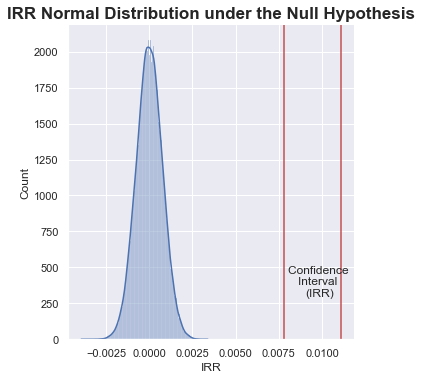

In [11]:
test_null_hypothesis(IRRs, name='IRR')

In [12]:
#Calculate P-value
p_value = 1 - stats.norm.cdf(irr, 0, np.std(IRRs))
print('P-Value:', p_value)

P-Value: 0.0


NIR
Confidence intervals (Overall Type I error rate = 0.025):
Lower Limit: -3027.6081
Upper Limit: -1641.0869


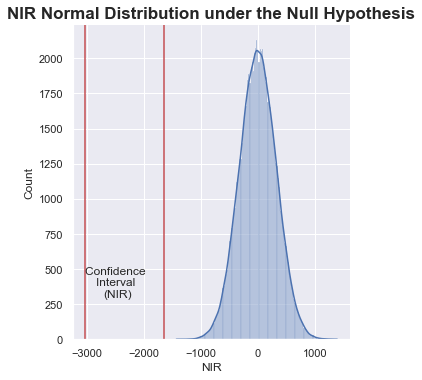

In [13]:
test_null_hypothesis(NIRs, name='NIR')

In [14]:
#Calculate P-value
p_value = 1 - stats.norm.cdf(nir, 0, np.std(NIRs))
print('P-Value:', p_value)

P-Value: 0.9999999999998215


# Modeling

In [15]:
def test_results(promotion_strategy, model=False):
    """Test results of the promotion strategy on the test set
    Arguments:
        promotion_strategy: function that returns 'Yes'/'No' values
            for whether or not to send the promotion to the customer
        model: ml model used in the promotion strategy
    Returns:
        None"""
    test_data = pd.read_csv('Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    
    if model == False:
        promos = promotion_strategy(df)
    else:
        promos = promotion_strategy(df, model)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = get_eval_metrics(score_df)

In [16]:
def promotion_strategy(df, model):
    """Indicates whether or not an individual should receive a promotion
    following a trained classification model
    Arguments:
        df: pandas dataframe (test data)
    Returns:
        promotion: array with 'Yes' and 'No' values for whether
            or not to send the promotion to the customer"""
    
    # Use model to decide whether or not the promotion should be sent to the customer
    y_hat = model.predict(df)
    
    # Relabel predictions [0, 1] to [No, Yes]
    y_hat = np.where(y_hat == 1, 'Yes', 'No')
    
    # Print the name of the model used for predicting
    print(model.__class__.__name__)
    
    return y_hat

In [17]:
treatment_group = df[df.Promotion == 'Yes']

X_train = treatment_group.drop(['purchase','Promotion'], axis=1)
y_train = treatment_group.purchase

## Baseline model "Logistic Regression"

In [18]:
lr_clf = LogisticRegression(class_weight = 'balanced')
lr_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [19]:
test_results(promotion_strategy, lr_clf)

LogisticRegression
IRR: 0.0146
NIR: -58.75


## BalancedRandomForestClassifier

In [20]:
metrics = ['accuracy','f1','precision','recall']

In [21]:
brf_clf0 = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
brf_clf0.fit(X_train, y_train)

BalancedRandomForestClassifier(n_jobs=-1, random_state=42)

In [22]:
test_results(promotion_strategy, brf_clf0)

BalancedRandomForestClassifier
IRR: 0.0168
NIR: 149.10


#### Applying GridSearchCV with 10-fold Cross Validation

In [23]:
%%time 
#10min 56s

'''BalancedRandomForestClassifier
parameters: 
    max_depth: maximum depth of each tree in the forest; (default = None, all leaves are expanded as much as possible)
                    generally, the deeper the tree, the more splits, which can lead to higher performance, as it
                    allows the model to better fit the data (lower bias), however this can also lead to higher
                    variance as the model can start to overfit the training data
    
    min_samples_split: minimum number of samples required to split an internal node; (default = 2)
                    this can reduce the number of splits, which can reduce overfitting, however, if too large, it
                    can also lead to underfitting the training set
    
    min_samples_leaf: mininum number of samples that must be present in a leaf/terminal node (end of the tree); (default = 1)
                    as before, a higher value can reduce overfitting but a too high value can lead to underfitting.
                    Specially in regression, a higher value can also smooth the model, by avoiding leaves with only one value
                    
    max_features: number of features to consider for best split (deafault = 'auto', total number of features)
                    a higher number will lead to better performance, but a too high number will also lead to overfitting.
                    Moreover, the higher the number, the more computationally expensive the model becomes.
    
    max_samples: number (or %) of samples to draw from X to train each base estimator (default = None, total num of samples)
                     The lower the value, the more randomness is introduced to the data.
                     --Only possible if Bootstrap = True.
    '''

param_grid = {'max_depth':[3, 5, 10],
              'min_samples_split':[2, 3],
              'min_samples_leaf':[1, 2],
              'max_features':[2, 3, 4, 5],
              'max_samples':[0.9, 1.0]
             }

brf_clf = GridSearchCV(estimator = BalancedRandomForestClassifier(n_estimators=200,
                                                       random_state = 42, 
                                                       n_jobs = -1, 
                                                       bootstrap  = True,
                                                       class_weight='balanced_subsample'),
                      param_grid = param_grid, 
                      cv = 10, 
                      scoring = metrics,
                      refit = 'recall',
                      error_score = 'raise', 
                      verbose = 2)
                     
brf_clf.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   2.6s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_dept

GridSearchCV(cv=10, error_score='raise',
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      random_state=42),
             param_grid={'max_depth': [3, 5, 10], 'max_features': [2, 3, 4, 5],
                         'max_samples': [0.9, 1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             refit='recall', scoring=['accuracy', 'f1', 'precision', 'recall'],
             verbose=2)

In [24]:
brf_clf.best_params_

{'max_depth': 3,
 'max_features': 3,
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [25]:
test_results(promotion_strategy, brf_clf.best_estimator_)

BalancedRandomForestClassifier
IRR: 0.0189
NIR: 415.20


## Interpreting our results

In [27]:
# Required library
from sklearn.inspection import permutation_importance

test_data = pd.read_csv('Test.csv', index_col='ID')
X_test = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_test = test_data.purchase

# Getting permutation importance
r = permutation_importance(brf_clf.best_estimator_, X_test, y_test,
                           random_state=7)

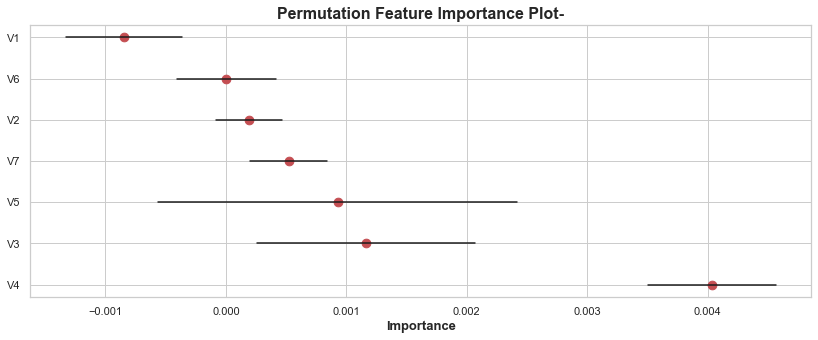

In [29]:
features_names = []
importance = []
lower, upper = [], []

for i in r.importances_mean.argsort()[::-1]:
    features_names.append(X_test.columns[i])
    importance.append(r.importances_mean[i])
    lower.append(r.importances_mean[i] - r.importances_std[i]) 
    upper.append(r.importances_mean[i] + r.importances_std[i]) 


with sns.axes_style("whitegrid"):
    yaxis = range(len(importance))

    # Plotting the avg importances
    plt.figure(figsize = (14,5))
    plt.scatter(importance, yaxis, color = 'r', s=75)

    # plotting std importances 
    plt.plot((lower, upper), (yaxis, yaxis), 'k-')
        
    # y ticks
    plt.yticks([i for i, _ in enumerate(features_names)], features_names)

    # other parameters
    plt.xlabel('Importance', weight ='bold', size = 13)
    plt.title('Permutation Feature Importance Plot', weight = 'bold', size = 16)

    plt.show()